In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models

from PIL import Image

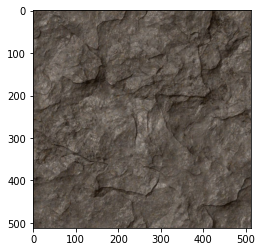

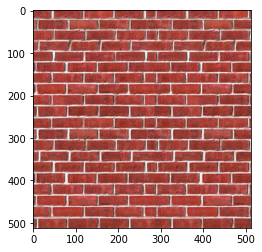

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
imsize = 512

loader = transforms.Compose([
    transforms.Resize(imsize),
    transforms.ToTensor()])

def image_loader(image_name):
    image = Image.open(image_name)
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)

def imshow(tensor, title=None):
    image = tensor.cpu().clone()
    image.data.clamp_(0, 1)
    image = image.squeeze(0)
    image = transforms.ToPILImage()(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)

style_img = image_loader("style.jpg")
content_img = image_loader("content.jpg")
input_img = content_img.clone()

assert style_img.size() == content_img.size(), "bad size"

plt.figure()
imshow(style_img)

plt.figure()
imshow(content_img)

In [0]:
class ContentBlock(nn.Module):
    def __init__(self, data):
        super(ContentBlock, self).__init__()
        self.data = data.detach()

    def forward(self, x):
        self.loss = F.mse_loss(x, self.data)
        return x
    
class StyleBlock(nn.Module):
    def __init__(self, data):
        super(StyleBlock, self).__init__()
        self.data = self._gram(data).detach()
        
    def _gram(self, matrix):
        a, b, c, d = matrix.size()
        x = matrix.view(a * b, c * d)
        return torch.mm(x, x.t()).div(a * b * c * d)

    def forward(self, x):
        G = self._gram(x)
        self.loss = F.mse_loss(G, self.data)
        return x
    
class NormalizationBlock(nn.Module):
    def __init__(self):
        super(NormalizationBlock, self).__init__()
        mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
        std = torch.tensor([0.229, 0.224, 0.225]).to(device)
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        return (img - self.mean) / self.std

In [4]:
cnn = models.vgg19(pretrained=True).features.to(device).eval()
print(cnn)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [0]:
def upgrade_model(style_img, content_img):
    content_layers = ['conv_1']
    style_layers = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']
    
    content_losses = []
    style_losses = []
    
    cnn = models.vgg19(pretrained=True).features.to(device).eval()
    model = nn.Sequential(NormalizationBlock().to(device))

    i = 0
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = f'conv_{i}'
        elif isinstance(layer, nn.ReLU):
            name = f'relu_{i}'
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = f'pool_{i}'
        elif isinstance(layer, nn.BatchNorm2d):
            name = f'bn_{i}'

        model.add_module(name, layer)

        if name in content_layers:
            target = model(content_img).detach()
            content_loss = ContentBlock(target)
            model.add_module(f"content_loss_{i}", content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            target = model(style_img).detach()
            style_loss = StyleBlock(target)
            model.add_module(f"style_loss_{i}", style_loss)
            style_losses.append(style_loss)

    for last in range(len(model) - 1, -1, -1):
        if isinstance(model[last], ContentBlock) or isinstance(model[last], StyleBlock):
            break

    model = model[:(last + 1)]

    return model, style_losses, content_losses

In [0]:
def train(content_img, style_img, input_img, epochs, style_weight, content_weight):
    model, style_losses, content_losses = upgrade_model(style_img, content_img)
    
    print(model)
    
    optimizer = optim.LBFGS([input_img.requires_grad_()])
    for epoch in range(epochs):

        def closure():
            input_img.data.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            loss = style_score * style_weight + content_score * content_weight
            loss.backward()

            return loss

        optimizer.step(closure)
        #plt.figure()
        #imshow(input_img, f'epoch: {epoch+1}/{epochs}')
        
    input_img.data.clamp_(0, 1)
    return input_img

In [7]:
%%time

epochs = 30
style_weight = 1e6
content_weight = 1

output = train(content_img, style_img, input_img, epochs, style_weight, content_weight)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Sequential(
  (0): NormalizationBlock()
  (conv_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (content_loss_1): ContentBlock()
  (style_loss_1): StyleBlock()
  (relu_1): ReLU()
  (conv_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (style_loss_2): StyleBlock()
  (relu_2): ReLU()
  (pool_2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (style_loss_3): StyleBlock()
  (relu_3): ReLU()
  (conv_4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (style_loss_4): StyleBlock()
  (relu_4): ReLU()
  (pool_4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (style_loss_5): StyleBlock()
)
CPU times: user 46.2 s, sys: 24.2 s, total: 1min 10s
Wall time: 1min 10s


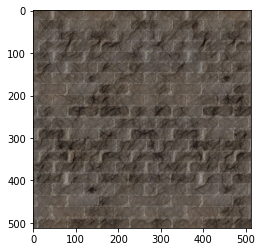

In [8]:
plt.figure()
imshow(output)